# Summarize and aggregate susceptibility scores across all queries (KG)

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.53890420.kevidu/ipykernel_60361/3431679233.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pand

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [17]:
from utils import construct_paths_and_dataset_kwargs, infer_context_type
from analysis_helpers import (
    compute_ttest_scores_dfs,
    save_ttest_df_to_json,
    count_open_closed_sig_group_match,
    count_num_significant_queries,
    combine_open_and_closed_dfs,
    write_to_latex_test_results_by_qid,
    write_to_latex_test_sus_and_per_results_by_qid,
    explode_val_df_per_qe,
    convert_test_results_dict_to_df,
    convert_test_results_dict_to_sig_proportion_df,
    build_mean_effect_sz_df,
    get_param_size,
    get_test_results_and_plot_per_model,
    plot_prop_queries_significant_per_model,
    plot_effect_sz_per_model,
    convert_entity_uri_to_entity,
)

#b40426


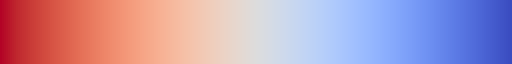

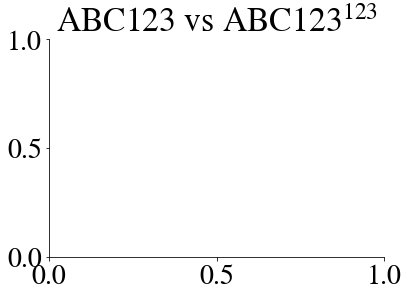

In [30]:
from analysis.mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

open_closed_colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
comparison_colormap = {
    "Familiar vs unfamiliar entities": palette[0],
    "Assertive vs base contexts": palette[1],
    "Negation vs base contexts": palette[3],
    "Relevant vs irrelevant contexts": palette[5],
}

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

cm = sns.color_palette("coolwarm_r", as_cmap=True)
cm.set_bad(cm(-np.inf))
print(matplotlib.colors.to_hex(cm(-np.inf)))
cm

In [6]:
##################
### Parameters ###
##################

# Data parameters
RAW_DATA_PATH = "data/YagoECQ/yago_qec copy.json"

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis", "summarize", "across-models"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [7]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [8]:
query_ids = list(yago_qec.keys())

In [31]:
analysis_dir = "analysis/summarize/across_models_kg"
os.makedirs(analysis_dir, exist_ok=True)

In [10]:
dataset_names_and_rdps = [("YagoECQ", RAW_DATA_PATH)]
seeds = [11]
model_id_and_quantize_tuples = [
    ("EleutherAI/pythia-70m-deduped", False, 32),
    ("EleutherAI/pythia-410m-deduped", False, 32),
    ("EleutherAI/pythia-1.4b-deduped", False, 32),
    ("EleutherAI/pythia-2.8b-deduped", False, 16),
    ("EleutherAI/pythia-6.9b-deduped", False, 16),
    # ("EleutherAI/pythia-6.9b-deduped", True, 16),
    ("EleutherAI/pythia-12b-deduped", True, 16),
]
max_contexts = [600]
max_entities = [100]
query_ids = list(yago_qec.keys())
# query_ids = ["http://schema.org/founder"]

ent_selection_fns = [
    "top_entity_uri_degree",
    "top_entity_namesake_degree",
    "random_sample",
]

entity_types = json.dumps(
    ["entities", "gpt_fake_entities"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
query_types = json.dumps(
    ["closed", "open"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
context_types = json.dumps(["assertive", "base", "negation"], separators=(",", ":"))

answer_map = dict()
# answer_map = {0: [" No", " no", " NO", "No", "no", "NO"], 1: [" Yes", " yes", " YES", "Yes", "yes", "YES"]}

cap_per_type = False
ablate = False
deduplicate_entities = True
uniform_contexts = True
overwrite = False


def convert_answer_map_to_tokens(
    model_id: str, answer_map: Dict[int, List[str]]
) -> str:
    answer_map_token_ids = dict()
    if answer_map:
        tokenizer = AutoTokenizer.from_pretrained(
            model_id,
            padding_side="left",
        )

        for k, v in answer_map.items():
            list_of_token_ids: List[List[str]] = tokenizer(v)["input_ids"]
            valid_token_ids = []
            for token_id in list_of_token_ids:
                if len(token_id) == 1:
                    valid_token_ids.append(token_id[0])
                else:
                    print(
                        f"tokenizer tokenized an answer map token into multiple tokens ({token_id}), which is invalid input."
                    )
            answer_map_token_ids[k] = valid_token_ids
        #     answer_map_token_ids = {
        #         k: [x[0] for x in tokenizer(v)["input_ids"] if len(x) == 1],
        #         for k, v in answer_map.items()
        #     }
    res = json.dumps(answer_map_token_ids, separators=(",", ":"))
    print(res)
    return res


df_dict = []
for ds, rdp in dataset_names_and_rdps:
    for seed in seeds:
        for model_id, do_quantize, bs in tqdm(model_id_and_quantize_tuples):
            answer_map_in_tokens = convert_answer_map_to_tokens(model_id, answer_map)
            for qid in tqdm(query_ids):
                for mc in max_contexts:
                    for me in max_entities:
                        for es in ent_selection_fns:
                            dict_vals = dict(
                                DATASET_NAME=ds,
                                RAW_DATA_PATH=rdp,
                                SEED=seed,
                                MODEL_ID=model_id,
                                LOAD_IN_8BIT=do_quantize,
                                QUERY_ID=qid,
                                MAX_CONTEXTS=mc,
                                MAX_ENTITIES=me,
                                CAP_PER_TYPE=cap_per_type,
                                ABLATE_OUT_RELEVANT_CONTEXTS=ablate,
                                DEDUPLICATE_ENTITIES=deduplicate_entities,
                                UNIFORM_CONTEXTS=uniform_contexts,
                                ENTITY_SELECTION_FUNC_NAME=es,
                                OVERWRITE=False,
                                ENTITY_TYPES=json.loads(entity_types),
                                QUERY_TYPES=json.loads(query_types),
                                CONTEXT_TYPES=json.loads(context_types),
                                ANSWER_MAP=json.loads(answer_map_in_tokens)
                                if json.loads(answer_map_in_tokens)
                                else None,
                            )
                            (
                                data_dir,
                                input_dir,
                                entities_path,
                                contexts_path,
                                queries_path,
                                answers_path,
                                val_data_path,
                                model_dir,
                                results_dir,
                                val_results_path,
                                mr_results_path,
                                data_id,
                                _,
                                DATASET_KWARGS_IDENTIFIABLE,
                            ) = construct_paths_and_dataset_kwargs(**dict_vals)
                            if os.path.isfile(val_results_path):
                                res = pd.read_csv(
                                    val_results_path,
                                    index_col=0,
                                    converters={
                                        # "contexts": literal_eval,
                                        "entity": literal_eval,
                                    },
                                )
                                closed_qfs = yago_qec[qid]["query_forms"]["closed"]
                                open_qfs = yago_qec[qid]["query_forms"]["open"]

                                res.loc[
                                    res["query_form"].isin(closed_qfs), "query_type"
                                ] = "closed"
                                res.loc[
                                    res["query_form"].isin(open_qfs), "query_type"
                                ] = "open"
                                res.loc[
                                    res["entity"].isin(
                                        [
                                            (x,)
                                            for x in yago_qec[qid]["gpt_fake_entities"]
                                        ]
                                    ),
                                    "entity_type",
                                ] = "gpt_fake_entities"
                                res.loc[
                                    res["entity"].isin(
                                        [(x,) for x in yago_qec[qid]["entities"]]
                                    ),
                                    "entity_type",
                                ] = "entities"
                                res["entity_classes"] = res["q_id"].apply(
                                    lambda x: yago_qec[qid]["entity_types"]
                                )
                                res["entity"] = res["entity"].apply(lambda x: x[0])
                                scores: List[dict] = res[
                                    [
                                        "entity",
                                        "answer",
                                        "query_form",
                                        "entity_type",
                                        "query_type",
                                        "entity_classes",
                                        "susceptibility_score",
                                        "contexts",
                                        "persuasion_scores_kl",
                                    ]
                                ].to_dict("records")
                                df_dict += [{**dict_vals, **d} for d in scores]

  0%|          | 0/6 [00:00<?, ?it/s]

{}


 17%|█▋        | 1/6 [00:58<04:53, 58.65s/it]

{}


 33%|███▎      | 2/6 [01:55<03:51, 57.88s/it]

{}


 50%|█████     | 3/6 [02:53<02:52, 57.54s/it]

{}


 67%|██████▋   | 4/6 [03:49<01:54, 57.17s/it]

{}


 83%|████████▎ | 5/6 [04:46<00:56, 56.89s/it]

{}


100%|██████████| 6/6 [05:46<00:00, 57.71s/it]


In [11]:
scores_df = pd.DataFrame(df_dict)
scores_df.drop(columns=["contexts", "persuasion_scores_kl", "OVERWRITE"]).to_csv(
    os.path.join(analysis_dir, "summarized_scores_all_models.csv"), index=False
)
scores_df["ENTITY_TYPES"] = scores_df["ENTITY_TYPES"].apply(lambda x: tuple(x))
scores_df["QUERY_TYPES"] = scores_df["QUERY_TYPES"].apply(lambda x: tuple(x))
scores_df["CONTEXT_TYPES"] = scores_df["CONTEXT_TYPES"].apply(lambda x: tuple(x))
scores_df.info(), scores_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292400 entries, 0 to 292399
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATASET_NAME                  292400 non-null  object 
 1   RAW_DATA_PATH                 292400 non-null  object 
 2   SEED                          292400 non-null  int64  
 3   MODEL_ID                      292400 non-null  object 
 4   LOAD_IN_8BIT                  292400 non-null  bool   
 5   QUERY_ID                      292400 non-null  object 
 6   MAX_CONTEXTS                  292400 non-null  int64  
 7   MAX_ENTITIES                  292400 non-null  int64  
 8   CAP_PER_TYPE                  292400 non-null  bool   
 9   ABLATE_OUT_RELEVANT_CONTEXTS  292400 non-null  bool   
 10  DEDUPLICATE_ENTITIES          292400 non-null  bool   
 11  UNIFORM_CONTEXTS              292400 non-null  bool   
 12  ENTITY_SELECTION_FUNC_NAME    292400 non-nul

(None,
 Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
        'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
        'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
        'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
        'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
        'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
        'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
       dtype='object'))

### Optionally, filter out fake entities that appear in the training data

In [12]:
scores_df[["MODEL_ID", "LOAD_IN_8BIT"]].value_counts()

MODEL_ID                        LOAD_IN_8BIT
EleutherAI/pythia-70m-deduped   False           49200
EleutherAI/pythia-1.4b-deduped  False           48800
EleutherAI/pythia-2.8b-deduped  False           48800
EleutherAI/pythia-410m-deduped  False           48800
EleutherAI/pythia-6.9b-deduped  False           48800
EleutherAI/pythia-12b-deduped   True            48000
Name: count, dtype: int64

In [13]:
set(query_ids).difference(
    scores_df[
        (scores_df["MODEL_ID"] == "EleutherAI/pythia-6.9b-deduped")
        & (scores_df["LOAD_IN_8BIT"] == False)
    ]["QUERY_ID"].unique()
)

{'http://schema.org/gtin', 'http://schema.org/motto', 'http://schema.org/url'}

In [14]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all
print("Pre-filtering:", len(scores_df))
df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
scores_df = scores_df[
    scores_df.apply(
        lambda x: x["entity_type"] == "entities"
        or fake_ent_freqs_dict.get(x["entity"], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
        axis=1,
    )
]

print("Post filtering:", len(scores_df))
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

Pre-filtering: 292400
Post filtering: 245024


In [15]:
scores_df["entity"].iloc[0]

'Crime and Punishment'

### Susceptibility Scores: Known vs Unknown

In [27]:
QID_TO_ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_predicate_degree_path.json"
with open(QID_TO_ENTITY_DEG_PATH) as f:
    qid_to_entity_degree = json.load(f)

qid_ent_deg_df = pd.DataFrame(
    [
        (qid, entity_uri, degree)
        for qid, entity_to_degree in qid_to_entity_degree.items()
        for entity_uri, degree in entity_to_degree.items()
    ],
    columns=["q_id", "entity_uri", "qid_ent_degree"],
)
# qid_ent_deg_df["q_id"] = qid_ent_deg_df["QUERY_ID"]
qid_ent_deg_df["entity"] = qid_ent_deg_df.apply(
    lambda x: convert_entity_uri_to_entity(x, yago_qec), axis=1
)
qid_ent_deg_df = qid_ent_deg_df.dropna()
# qid_ent_deg_df["entity"] = qid_ent_deg_df["entity"].apply(lambda x: (x,))
qid_ent_deg_df["qid_ent_degree"] = pd.to_numeric(qid_ent_deg_df["qid_ent_degree"])
scores_df["q_id"] = scores_df["QUERY_ID"]
scores_df = scores_df.merge(qid_ent_deg_df, on=["q_id", "entity"])
scores_df["log_qid_ent_degree"] = scores_df["qid_ent_degree"].apply(np.log)
scores_df

,DATASET_NAME,RAW_DATA_PATH,SEED,MODEL_ID,LOAD_IN_8BIT,QUERY_ID,MAX_CONTEXTS,MAX_ENTITIES,CAP_PER_TYPE,ABLATE_OUT_RELEVANT_CONTEXTS,...,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores_kl,q_id,entity_uri,qid_ent_degree,log_qid_ent_degree
0,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.078727,"[""Definitely, 'A Christmas Carol' is about Isr...","[0.23654992819031548, 0.06147735224624566, 0.0...",http://schema.org/about,http://yago-knowledge.org/resource/Crime_and_P...,2,0.693147
1,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.086017,"[""Definitely, 'A Christmas Carol' is about Isr...","[0.2072897442686467, 0.11232347902345786, 0.07...",http://schema.org/about,http://yago-knowledge.org/resource/Stranger_Th...,3,1.098612
2,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.080618,"[""Definitely, 'A Christmas Carol' is about Isr...","[0.13167128913944287, 0.07938829101337914, 0.0...",http://schema.org/about,http://yago-knowledge.org/resource/Sleeping_Be...,1,0.000000
3,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.080618,"[""Definitely, 'A Christmas Carol' is about Isr...","[0.13167128913944287, 0.07938829101337914, 0.0...",http://schema.org/about,http://yago-knowledge.org/resource/Sleeping_Be...,4,1.386294
4,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-70m-deduped,False,http://schema.org/about,600,100,False,False,...,entities,closed,{'http://schema.org/CreativeWork': 0.586206896...,0.071941,"[""Definitely, 'A Christmas Carol' is about Isr...","[0.10235214686042188, 0.05808626597382959, 0.0...",http://schema.org/about,http://yago-knowledge.org/resource/Indiana_Jon...,2,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146219,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-12b-deduped,True,reverse-http://yago-knowledge.org/resource/ter...,600,100,False,False,...,entities,open,{'http://schema.org/Organization': 0.404761904...,1.446731,"['Definitely, Altitude Allies is the terminus ...","[2.219612042039812, 0.33665520646395664, 0.600...",reverse-http://yago-knowledge.org/resource/ter...,http://yago-knowledge.org/resource/Kansas,19,2.944439
146220,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-12b-deduped,True,reverse-http://yago-knowledge.org/resource/ter...,600,100,False,False,...,entities,open,{'http://schema.org/Organization': 0.404761904...,1.376649,"['Definitely, Altitude Allies is the terminus ...","[2.1901059300959567, 0.31161297825608264, 0.59...",reverse-http://yago-knowledge.org/resource/ter...,http://yago-knowledge.org/resource/West_Virginia,3,1.098612
146221,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-12b-deduped,True,reverse-http://yago-knowledge.org/resource/ter...,600,100,False,False,...,entities,open,{'http://schema.org/Organization': 0.404761904...,2.011875,"['Definitely, Altitude Allies is the terminus ...","[2.4264225827506514, 1.1557043131662912, 1.198...",reverse-http://yago-knowledge.org/resource/ter...,http://yago-knowledge.org/resource/Geneva,2,0.693147
146222,YagoECQ,data/YagoECQ/yago_qec copy.json,11,EleutherAI/pythia-12b-deduped,True,reverse-http://yago-knowledge.org/resource/ter...,600,100,False,False,...,entities,open,{'http://schema.org/Organization': 0.404761904...,1.484443,"['Definitely, Altitude Allies is the terminus ...","[1.5699096863765636, 0.4451820434056285, 0.641...",revers

In [25]:
scores_df["entity"].iloc[0]

'Crime and Punishment'

In [24]:
qid_ent_deg_df["entity"].iloc[0]

('Rock School',)

In [28]:
scores_per_model = scores_df.groupby("MODEL_ID")
scores_per_model = sorted(scores_per_model, key=lambda x: get_param_size(x[0]))
print(list(zip(*scores_per_model))[0])

('EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped')


In [ ]:
model_id, df_m = next(iter(scores_per_model))
df_m.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
      dtype='object')

In [47]:
def plot_all_models_sus_vs_kg_deg(
    df_all_models: List[Tuple[str, pd.DataFrame]],
    title: str,
    save_path: str,
):
    """
    Args:
        df_all_models - list of (model-name, df)-tuples containing at least a score_col and type_col with values of group1 and group2.

    Returns:
        (1) a dict mapping from {model_name -> df of the effect sizes and p-values for each open query}
        (2) a dict mapping from {model_name -> df of the effect sizes and p-values for each closed query}
        (3) a dict mapping from {model_name -> dict containing the percent of significant results for both open and closed queries}

    Plots:
        a big page-sized thing with effect sizes and p-values for all models for both open and closed queries
    """
    n_rows_sf, n_cols_sf = int(len(df_all_models) // 2), 2
    fig = plt.figure(constrained_layout=True, figsize=(n_cols_sf * 12, n_rows_sf * 7))
    subfigs = fig.subfigures(nrows=n_rows_sf, ncols=n_cols_sf)
    for i, (model_id, df_m) in enumerate(df_all_models):
        subfig = subfigs[i // n_cols_sf, i % n_cols_sf]
        print(f"MODEL ID: {model_id}")
        colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
        axes = subfig.subplots(nrows=1, ncols=2)
        scatter_kws = {"s": 60, "alpha": 0.3, "ec": None}

        for i, qt in enumerate(reversed(df_m["query_type"].unique())):
            ax = axes[i]
            sns.scatterplot(
                data=df_m[df_m["query_type"] == qt],
                x="qid_ent_degree",
                y="susceptibility_score",
                ax=ax,
                color=colormap[qt],
                legend=None,
                **scatter_kws,
            )
            ax.set_title(qt.capitalize(), size="x-large")
            ax.set_xlabel("Entity degree", size="large")
            ax.set_ylabel("Score", size="large")
            ax.set_xscale("log")
            ax.tick_params(axis="both", which="major", labelsize="large")

        subfig.suptitle(f"{model_id.split('/')[1].split('-')[1]}", size="x-large")

    fig.suptitle(
        title,
        y=1.05,
        size="x-large",
    )

    fig.savefig(save_path, bbox_inches="tight", dpi=100)

MODEL ID: EleutherAI/pythia-70m-deduped
MODEL ID: EleutherAI/pythia-410m-deduped
MODEL ID: EleutherAI/pythia-1.4b-deduped
MODEL ID: EleutherAI/pythia-2.8b-deduped
MODEL ID: EleutherAI/pythia-6.9b-deduped
MODEL ID: EleutherAI/pythia-12b-deduped


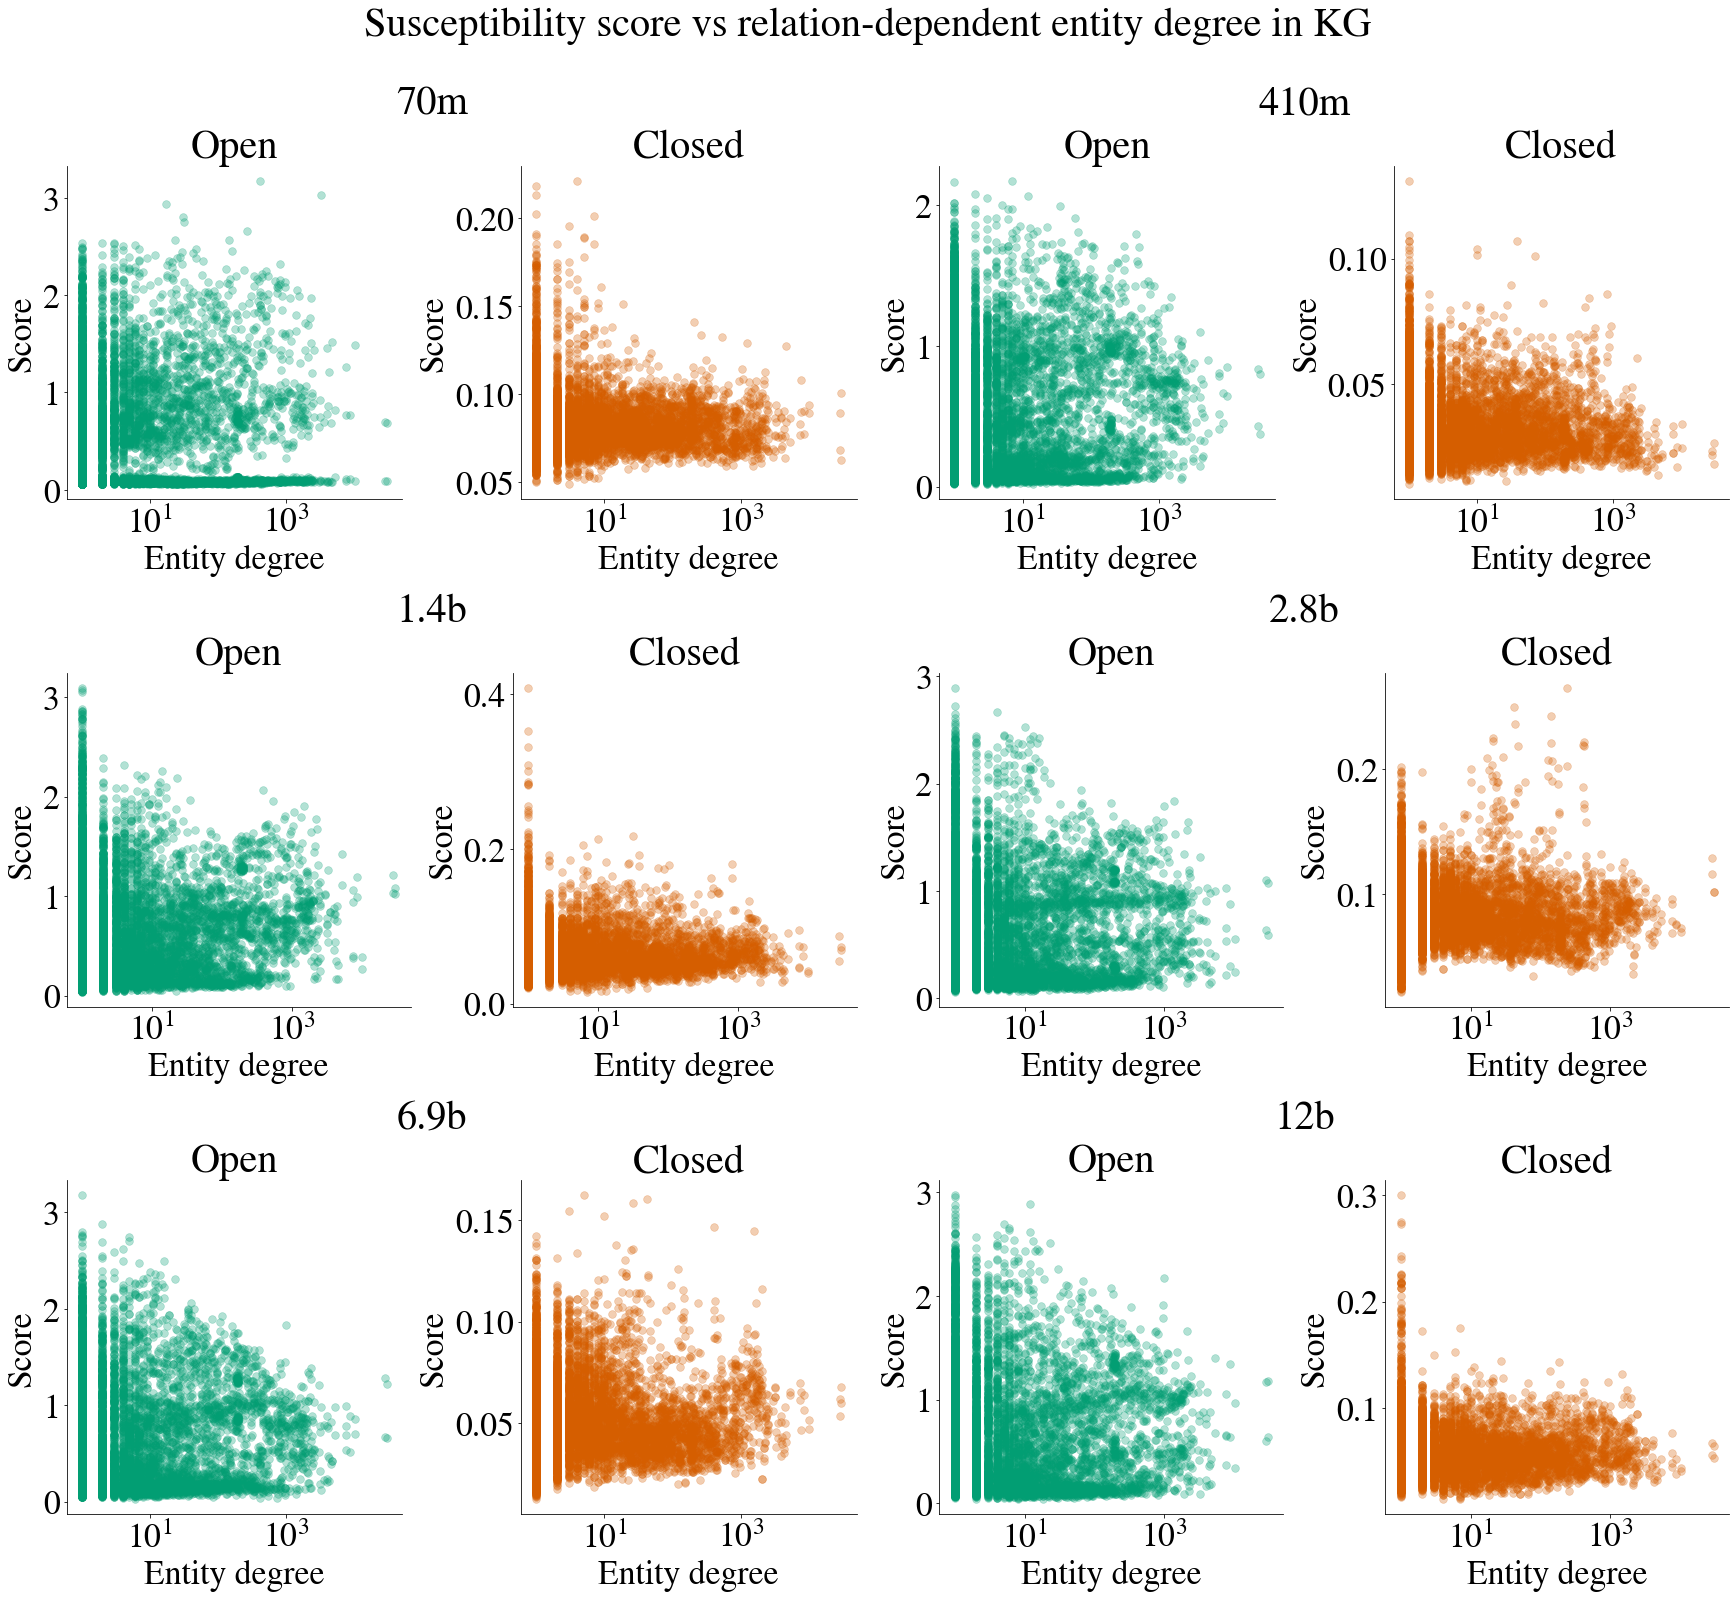

In [48]:
plot_all_models_sus_vs_kg_deg(
    scores_per_model,
    title="Susceptibility score vs relation-dependent entity degree in KG",
    save_path=os.path.join(analysis_dir, "plot_sus_score_vs_kg_deg_all_models.png"),
)